<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/bnp_paribas_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 27th July, 2021
My folder: C:\Users\ashok\OneDrive\Documents\bnp_paribas_insurance
           /home/ashok/Documents/bnp_paribas_insurance/
Ref:
    Kaggle problem: https://www.kaggle.com/c/bnp-paribas-cardif-claims-management
    https://github.com/catboost/tutorials/blob/master/advanced_tutorials/kaggle_paribas.ipynb

Evaluation:
    logloss
    https://www.kaggle.com/c/bnp-paribas-cardif-claims-management#evaluation

Objectives:
    i)   Learn to work with catboost
    ii)  Plotting missingvalues graphs
            a. Matrix plots
            b. Heatmap/correlation plots
            c. dendogram plots
    ii)  Plotting ROC curve in python
    iii) Feature importance
    iv)  Grid search--parameter tuning

"""


In [1]:
! pip install catboost

     |████████████████████████████████| 69.2 MB 4.8 kB/s 


In [2]:
# 1.0 Call libraries
#%reset -f
import pandas as pd        # Data manipulation
import numpy as np         # Array manipulation

# 1.1 Modeling libraries
from sklearn.model_selection import train_test_split
# 1.1.1 For parameter-search over grid
from sklearn.model_selection import GridSearchCV
# conda install -c conda-forge catboost 
from catboost import CatBoostClassifier   # For classification
from catboost import Pool                 # Pool is catboost's internal data structure

# 1.2 Model performance
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# 1.3 For plotting
# conda install -c conda-forge scikit-plot
from sklearn.metrics import roc_curve
#import scikitplot as skplt      # For roc graphs
import matplotlib.pyplot as plt
import seaborn as sns

# 1.4 Plot missing values
#     Ref: https://github.com/ResidentMario/missingno
#     pip install missingno
import missingno as msno      # For missing plots


# 1.5 Misc
import os
import time
import gc

In [3]:
# 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [40]:
filePath = "/gdrive/MyDrive/bnp_paribas"
# 2.0 Change working directory and read file
os.chdir(filePath)
#os.chdir("C:/Users/ashok/OneDrive/Documents/bnp_paribas_insurance")
# 2.1
train_df = pd.read_csv('train.csv.zip')

In [41]:
# 2.2 Explore data
print(train_df.shape)          # 114321, 133
print()
print(train_df.columns)        # Column names
print()
print(train_df.dtypes)         # Column types
print()
# 2.3 Count of different dtypes
#     float64: 138, object: 19, int64: 6
train_df.dtypes.value_counts()
# Memory usage
print()
print(train_df.memory_usage().sum())  # 121637672 = 121mb

(114321, 133)

Index(['ID', 'target', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8',
       ...
       'v122', 'v123', 'v124', 'v125', 'v126', 'v127', 'v128', 'v129', 'v130',
       'v131'],
      dtype='object', length=133)

ID          int64
target      int64
v1        float64
v2        float64
v3         object
           ...   
v127      float64
v128      float64
v129        int64
v130      float64
v131      float64
Length: 133, dtype: object



float64    108
object      19
int64        6
dtype: int64


121637672


In [42]:
train_df['target'].value_counts()

1    87021
0    27300
Name: target, dtype: int64

In [43]:
df = train_df.select_dtypes(include = ['float64'])
print(df.max().max())
print(df.min().min())

20.0000009996
-9.99993198897e-07


In [44]:
# StackOverFlow: https://stackoverflow.com/a/1658752
print(np.finfo('float64'))
print(np.finfo('float32'))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------



In [45]:
df = train_df.select_dtypes(include = ['int64'])
print(df.max().max())
print(df.min().min())
int_cols = df.columns
int_cols

228713
0


Index(['ID', 'target', 'v38', 'v62', 'v72', 'v129'], dtype='object')

In [46]:
print(np.iinfo('int64'))
print(np.iinfo('int32'))
print(np.iinfo('int16'))

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



In [47]:
train_df[int_cols] = train_df[int_cols].astype('int16')
train_df.dtypes.value_counts()
print()
print(train_df.memory_usage().sum())  # 117522116 = 117mb

float64    108
object      19
int16        6
dtype: int64


117522116


In [48]:
# 2.4.1 Just look at data upto IInd index
train_df.loc[:20 , train_df.dtypes == "object"]  # All have char data

,v3,v22,v24,v30,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,C,XDX,C,C,A,C,G,DI,C,F,B,D,E,A,E,B,O,NaN,AU
1,C,GUV,C,C,A,E,G,DY,A,F,B,D,D,B,B,A,U,G,AF
2,C,FQ,E,NaN,A,C,F,AS,A,B,B,B,E,G,C,B,S,NaN,AE
3,C,ACUE,D,C,B,C,H,BW,A,F,B,D,B,B,B,B,J,NaN,CJ
4,C,HIT,E,NaN,A,I,H,NaN,C,F,B,D,C,G,C,A,T,G,Z
5,C,AYX,A,NaN,A,I,K,DX,A,F,B,D,I,G,C,A,D,X,X
6,C,NFD,E,G,A,C,A,AS,A,F,B,D,E,B,B,B,I,NaN,BJ
7,C,AHBW,D,C,A,I,C,DP,C,F,B,D,C,A,E,A,F,M,BY
8,NaN,GKQ,E,NaN,NaN,D,H,AF,B,B,B,B,P,C,D,C,L,NaN,S
9,C,PYF,C,C,A,I,A,NaN,A,F,B,D,C,A,E,A,J,P,E


In [49]:
# Calculate number of levels in each
df = train_df.loc[: , train_df.dtypes == "object"]
print()
df['v22'].value_counts()
print()
df['v24'].value_counts()


AGDF    2386
YGJ     2119
QKI      668
PWR      649
HZE      423
        ... 
ZQZ        1
UNO        1
EFD        1
OKQ        1
POM        1
Name: v22, Length: 18210, dtype: int64

E    55177
D    26333
C    20872
B     8150
A     3789
Name: v24, dtype: int64

In [50]:
for i in df.columns:
  print(i,len(df[i].value_counts().index.values))

v3 3
v22 18210
v24 5
v30 7
v31 3
v47 10
v52 12
v56 122
v66 3
v71 9
v74 3
v75 4
v79 18
v91 7
v107 7
v110 3
v112 22
v113 36
v125 90


In [51]:
train_df.loc[:, train_df.dtypes == 'object'].isnull().sum().sort_values(ascending = False)
train_df.loc[:, train_df.dtypes == 'float64'].isnull().sum().sort_values(ascending = False)
train_df.loc[:, train_df.dtypes == 'int16'].isnull().sum().sort_values(ascending = False)


v30     60110
v113    55304
v56      6882
v3       3457
v31      3457
v22       500
v112      382
v125       77
v52         3
v91         3
v107        3
v74         0
v75         0
v66         0
v79         0
v47         0
v24         0
v110        0
v71         0
dtype: int64

v102    51316
v85     50682
v119    50680
v123    50678
v51     50678
        ...  
v12        86
v50        86
v10        84
v114       30
v14         4
Length: 108, dtype: int64

v129      0
v72       0
v62       0
v38       0
target    0
ID        0
dtype: int64

## Patterns in missing data

In [26]:
sample = train_df.sample(frac = 0.1)
sample.shape  # 11432, 133)

(11432, 133)

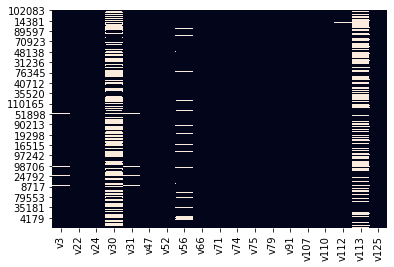

In [27]:
sns.heatmap(sample.loc[:, sample.dtypes=='object' ].isnull(), cbar=False);

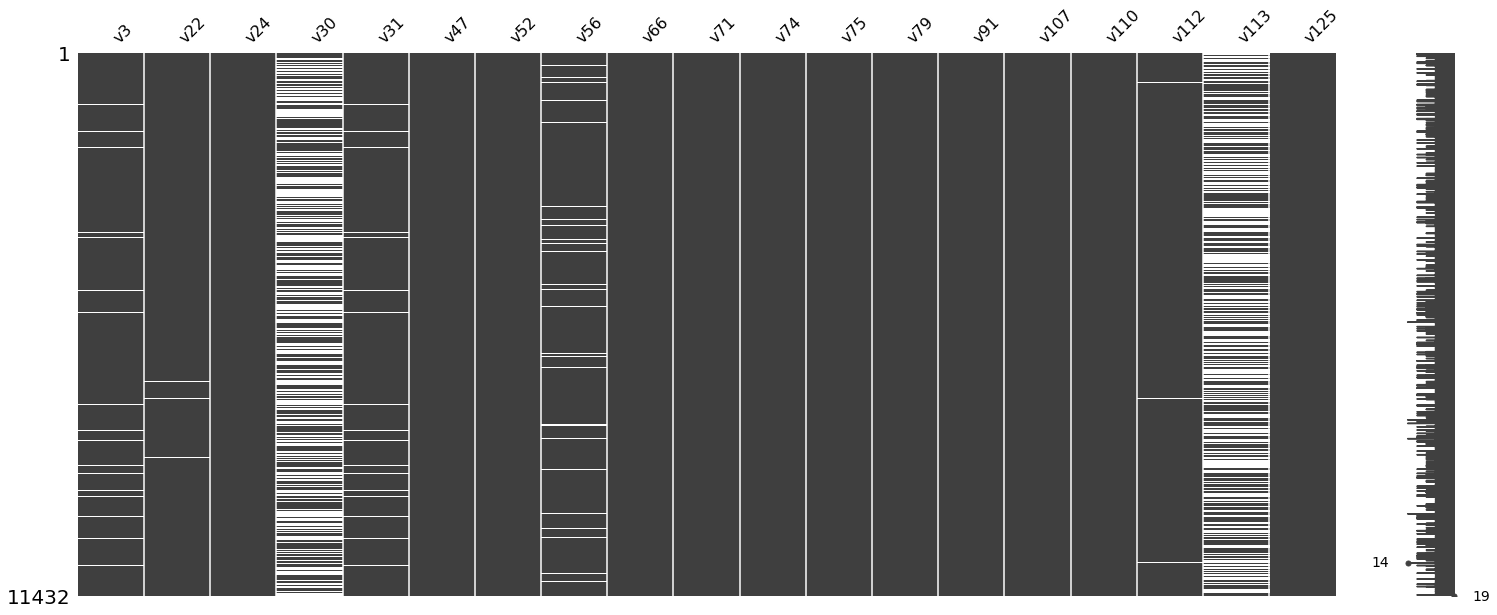

In [28]:
msno.matrix(sample.loc[:, sample.dtypes=='object' ]);

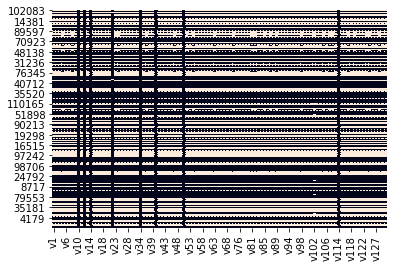

In [29]:
sns.heatmap(sample.loc[:, sample.dtypes=='float64' ].isnull(), cbar=False);

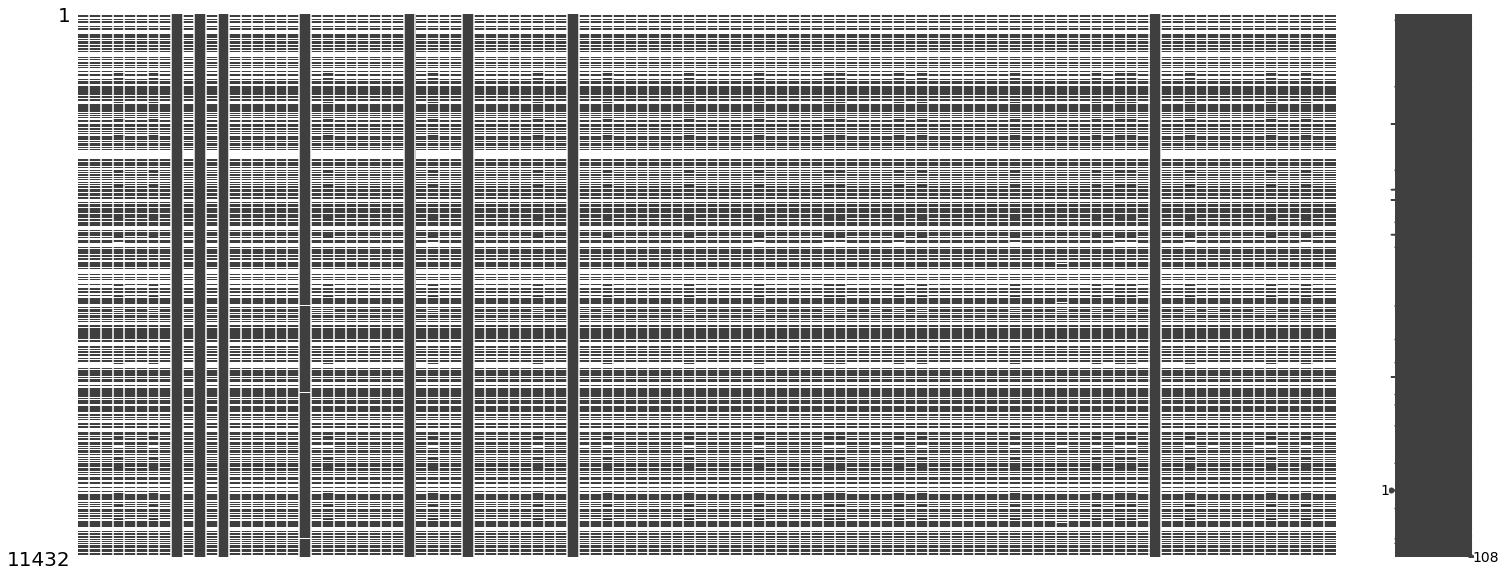

In [30]:
msno.matrix(sample.loc[:, sample.dtypes=='float64' ]);

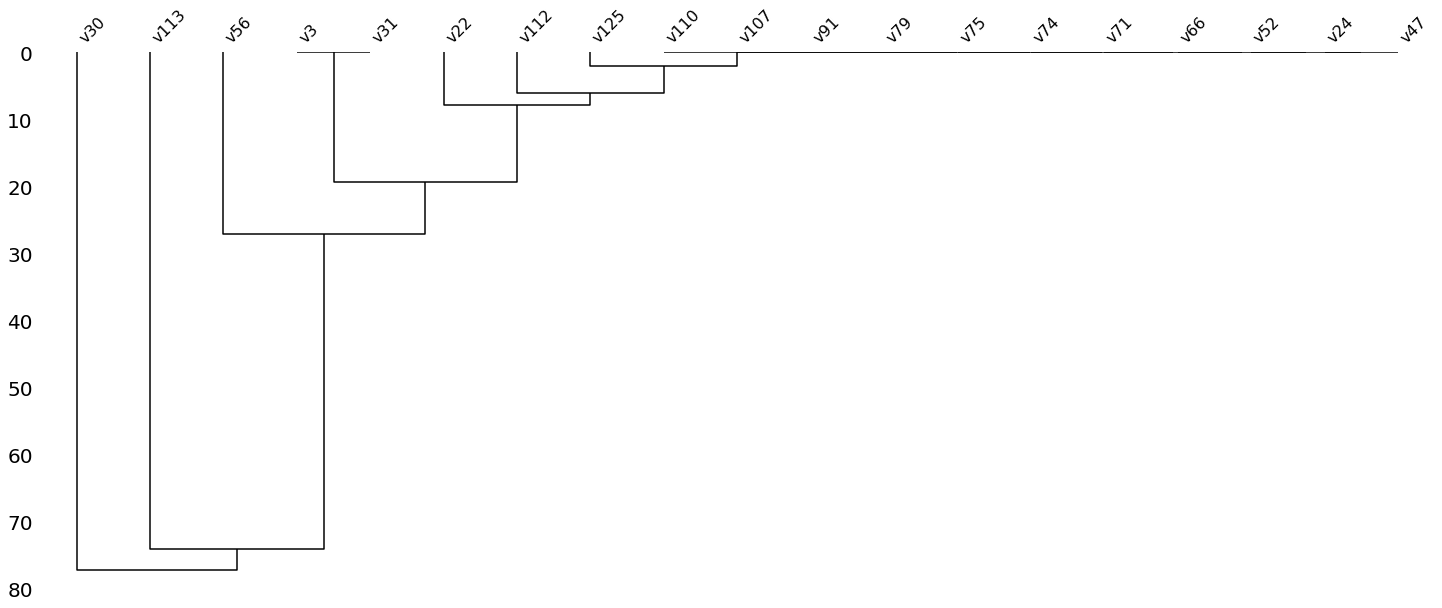

In [31]:
msno.dendrogram(sample.loc[:, sample.dtypes=='object' ])

In [52]:

# 2.9 Fill up missing values arbitrarily.
#     Fill up all just with one value
#     In object type, it will appear as a catageory
#     And in float type, it will be a number
train_df.fillna(-9999, inplace=True)

In [33]:

# 2.10 Check dtypes again
train_df.dtypes.value_counts()           # fl: 108, Ob: 19, int: 6


float64    108
object      19
int16        6
dtype: int64

In [53]:

# 3.0 Drop columns not needed
# 3.1 Get data with all relevant predictors
X = train_df.drop(axis=1,
                  columns=['ID','target']
                  )

# 3.2 Target
y = train_df.target

In [54]:

# 4. Split data into train/test using train_test_split()
X_train,X_test,y_train,y_test = train_test_split(X,
	                                             y,
	                                             test_size = 0.50   # To save time
	                                             )

# 4.1 Check shapes
X_train.shape
X_test.shape
y_train.shape
y_test.shape


(57160, 131)

(57161, 131)

(57160,)

(57161,)

In [ ]:

# 4.2 Let us define what we would consider to be
#      a categorical variable and keep a list of
#     all categorical columns
#      We need this list so as to specify in CatBoost

# 4.2.1 First get unique values per col
d_cat = X.apply(pd.Series.nunique)
d_cat                  # Look at them


In [ ]:

# 4.3 Let us say those columns with
#     unique values < 30000 are categorical
#     np.where() is same as which() in R
#     Note that np.where(d_cat < 30000) is a tuple
#     (array([2,21..]) , ) with first element as
#     an array inside it.
#     Hence the syntax:
#       np.where(d_cat < 30000)[0]  gets the Ist element
#     ie the complete array
d_cat < 30000           # Data being anonymous, an arbitray decision
np.where(d_cat < 30000)
cat_features_ids = np.where(d_cat < 30000)[0].tolist()
cat_features_ids
len(cat_features_ids)   # 23 in all out of 131
X.shape                 # 114321 X 131


In [59]:
cat = list(train_df.select_dtypes(include = "object").columns.values)
cat

['v3',
 'v22',
 'v24',
 'v30',
 'v31',
 'v47',
 'v52',
 'v56',
 'v66',
 'v71',
 'v74',
 'v75',
 'v79',
 'v91',
 'v107',
 'v110',
 'v112',
 'v113',
 'v125']

In [60]:

"""
5. Start modeling

Ref: https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/
CatBoostClassifier:
      Training and applying models for the
      classification problems. When using
      the applying methods only the probability
      that the object belongs to the class is
      returned. Provides compatibility with the
      scikit-learn tools.

"""
# 5.1 Instantiate the CatBoostClassifier() object
start = time.time()
clf = CatBoostClassifier(
                        learning_rate=0.1,
	                      iterations=300,   #  max no of trees
	                      random_seed=0,
                        thread_count = 2,
                        eval_metric = 'AUC',  # Recall,Precision,F1,TotalF1,
                                              #  Accuracy,Kappa,AUC
	                      verbose =1
	                     )



'\n5. Start modeling\n\nRef: https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/\nCatBoostClassifier:\n      Training and applying models for the\n      classification problems. When using\n      the applying methods only the probability\n      that the object belongs to the class is\n      returned. Provides compatibility with the\n      scikit-learn tools.\n\n'

In [61]:

"""
ref: https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier_fit-docpage/#python-reference_catboostclassifier_fit
fit
 Train the model
"""

# 5.2 Use now the 'clf' object to learn from data
#     and create model
start = time.time()
clf.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        # Specify which columns are categorical in nature
        cat_features=cat  # cat_features_ids
        )
# Result may say:
#  Shrink model to first 206 iterations.
#    Meaning that out of 300 trees only 206 trees are kept

end = time.time()
(end - start)/60

'\nref: https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier_fit-docpage/#python-reference_catboostclassifier_fit\nfit\n Train the model\n'

0:	test: 0.7111733	best: 0.7111733 (0)	total: 346ms	remaining: 1m 43s
1:	test: 0.7197467	best: 0.7197467 (1)	total: 792ms	remaining: 1m 57s
2:	test: 0.7215407	best: 0.7215407 (2)	total: 1.25s	remaining: 2m 3s
3:	test: 0.7296032	best: 0.7296032 (3)	total: 1.59s	remaining: 1m 57s
4:	test: 0.7311808	best: 0.7311808 (4)	total: 1.98s	remaining: 1m 56s
5:	test: 0.7302661	best: 0.7311808 (4)	total: 2.37s	remaining: 1m 56s
6:	test: 0.7309097	best: 0.7311808 (4)	total: 2.75s	remaining: 1m 55s
7:	test: 0.7309175	best: 0.7311808 (4)	total: 3.14s	remaining: 1m 54s
8:	test: 0.7323740	best: 0.7323740 (8)	total: 3.42s	remaining: 1m 50s
9:	test: 0.7332319	best: 0.7332319 (9)	total: 3.78s	remaining: 1m 49s
10:	test: 0.7338955	best: 0.7338955 (10)	total: 3.96s	remaining: 1m 44s
11:	test: 0.7341817	best: 0.7341817 (11)	total: 4.42s	remaining: 1m 46s
12:	test: 0.7343239	best: 0.7343239 (12)	total: 4.78s	remaining: 1m 45s
13:	test: 0.7352941	best: 0.7352941 (13)	total: 5.17s	remaining: 1m 45s
14:	test: 0.7

2.0758543690045674

In [62]:

"""
predict
   Apply the model to the given dataset.
   Note. The model can not be correctly
   applied if the order of the columns
   in the testing and training datasets
   differs.
"""

# 5.3  Apply model to make class-wise predictions
prediction = clf.predict(X_test,
                         verbose = True,
                         prediction_type='Class'  # Options: Probability
                         )


'\npredict\n   Apply the model to the given dataset.\n   Note. The model can not be correctly\n   applied if the order of the columns\n   in the testing and training datasets\n   differs.\n'

In [63]:

# 5.4 Apply model to make probaility predictions
#     IInd col of prediction_prob is prob of being '1'.
prediction_prob = clf.predict(X_test,
                              verbose = True,
                              prediction_type='Probability'
                             )



In [64]:

# 5.5 Dataframe of actual vs predicted class-values.
df = pd.DataFrame(
                     {
                     'actualID':y_test,
                     'Predicted':prediction
                     }
                 )


In [65]:

# 5.6 Confusion matrix
confusion_matrix(df.actualID,
	             df.Predicted
	             )


array([[ 2896, 10797],
       [ 1392, 42076]])

In [66]:

# 5.7 Calculate performance parameters
#     ravel() flattens the matrix
tn_1, fp_1, fn_1, tp_1 = confusion_matrix(df.actualID,
	                              df.Predicted).ravel()

# 5.8 Performance parameters
print("accu:     ", (tp_1 + tn_1)/(tp_1 + fp_1 + fn_1 + tn_1))
print("precision:", tp_1/(tp_1 + fp_1) )
print("recall:   ", tp_1/(tp_1 + fn_1) )



accu:      0.7867602036353458
precision: 0.7957936943241352
recall:    0.9679764424404159


In [ ]:

# 5.9 AUC plot
# Ref: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
skplt.metrics.plot_roc_curve(y_test, prediction_prob)
plt.show()



In [68]:

# 6. Get feature importance
#    First transform data into a special matrix
#    as rquired by catboost

train_pool = Pool(X_train, y_train, cat_features=cat_features_ids)


In [69]:

# 6. Get feature importance
#    First transform data into a special matrix
#    as rquired by catboost

train_pool = Pool(X_train, y_train, cat_features=cat_features_ids)


In [ ]:

# 6.1 Calculate feature importance using model object (clf)

feature_importances = clf.get_feature_importance(data=train_pool)
feature_importances
feature_names = X_train.columns


In [ ]:

# 6.2 Create dataframe of feature importance, col-name wise
df_imp = pd.DataFrame(
                       { 'feature_names':feature_names,
                         'feature_impt': feature_importances
                        }
                     )

df_imp
